<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/Abhi_CTCF_Replication_Same_Training_Test_Splits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import division, print_function

In [14]:
!pip install pyfasta
!pip install deeptools
!pip install momma_dragonn

!apt-get install bedtools
  
#Get hg38 fasta by download 2bit and then converting to fa
![[ -f hg38.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.2bit -O hg38.2bit  
![[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa
![[ -f hg38.genome.fa ]] || ./twoBitToFa hg38.2bit hg38.genome.fa
  
#download hg38 chromsizes file
![[ -f hg38.chrom.sizes ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes -O hg38.chrom.sizes

  Running setup.py bdist_wheel for pyfasta ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/ef/57/33/7b569168243dfbfe60bd3533e6897d170b391f2ce58df9d275
Successfully built pyfasta
    100% |████████████████████████████████| 3.3MB 9.7MB/s 
    100% |████████████████████████████████| 9.7MB 1.1MB/s 
    100% |████████████████████████████████| 71kB 20.4MB/s 
    100% |████████████████████████████████| 37.8MB 814kB/s 
    100% |████████████████████████████████| 3.1MB 11.1MB/s 
    100% |████████████████████████████████| 71kB 21.8MB/s 
    100% |████████████████████████████████| 8.1MB 5.1MB/s 
    100% |████████████████████████████████| 552kB 22.0MB/s 
  Running setup.py bdist_wheel for deeptools ... - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/26/7b/1a/e828c248cbb05db00a41118e24c0435bcdbf1b750f4dd2c0c8
  Running setup.py bdist_wheel for numpydoc ... - done
  Stored in directory: /root/.cache/pip/wheels/ea/55/7f/3e25d754760ccd62d

In [21]:
!curl -L "https://docs.google.com/uc?export=download&id=1ikkvxPo7KFW4RdMRYGXecqYXflHEsR_x" > test.tsv
!wc -l test.tsv
!curl -L "https://docs.google.com/uc?export=download&id=1-Xx0ETw-4yECSGO_oQVqqeJPxlja1XlZ" > val.tsv
!wc -l val.tsv
!curl -L "https://docs.google.com/uc?export=download&id=16hvzZyvcANBNXm_6xQU1mCIkJk6nKu3l" > train.tsv
!wc -l train.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   2832      0 --:--:-- --:--:-- --:--:--  2832
100  267k  100  267k    0     0   893k      0 --:--:-- --:--:-- --:--:--  893k
7241 test.tsv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1243      0 --:--:-- --:--:-- --:--:--  1239
100  267k  100  267k    0     0   579k      0 --:--:-- --:--:-- --:--:--  579k
7242 val.tsv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1716      0 --:--:-- --:--:-- --:--:--  1716
100 1247k  100 1247k    0     0  2687k      0 --:--:-- --:--:-- --:--:-- 52.9M
33794 train.tsv


In [22]:
!bedtools intersect -a val.tsv -b train.tsv | wc -l
!bedtools intersect -a test.tsv -b train.tsv | wc -l
!bedtools intersect -a test.tsv -b val.tsv | wc -l

1471
1483
323


In [30]:
!ls

gdrive		  hg38.genome.fa		  test.tsv.gz	val.tsv.gz
hg38.2bit	  idr_optimal_file.narrowPeak.gz  train.tsv.gz
hg38.chrom.sizes  sample_data			  twoBitToFa


In [0]:
import keras
from keras.models import Model
from momma_dragonn.data_loaders import pyfasta_data_loader
import six
from scipy.stats import spearmanr
import numpy as np


def get_single_stream_data_generator(bed_source, batch_size):

  return pyfasta_data_loader.SingleStreamSeqOnly(
               batch_size=batch_size,
               bed_source=bed_source,
               fasta_data_source="hg38.genome.fa",
               rc_augment=True,
               num_to_load_for_eval=100, #not used
               labels_dtype="float",
               wrap_in_keys=["sequence", "output"],
               randomize_after_pass=True)


def get_core_model(num_conv_filters,
                   conv_filter_length,
                   pool_length_and_stride,
                   num_dense_units):
  input = keras.layers.Input(shape=(1000,4), name="sequence")
  conv1 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters, kernel_size=conv_filter_length,
              padding="same")(input)
  conv1relu = keras.layers.core.Activation(activation="relu")(conv1)
  conv2 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv1relu)
  conv2relu = keras.layers.core.Activation(activation="relu")(conv2)
  conv3 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv2relu)
  conv3relu = keras.layers.core.Activation(activation="relu")(conv3)
  avgpool = keras.layers.convolutional.AveragePooling1D(
                pool_size=pool_length_and_stride,
                strides=pool_length_and_stride)(conv3relu)
  flatten = keras.layers.core.Flatten()(avgpool)
  dense1 = keras.layers.core.Dense(units=num_dense_units[0])(flatten)
  dense1relu = keras.layers.core.Activation(activation="relu")(dense1)
  
  return (input, dense1relu)


def train_positivesonly_regression_model(num_outputs,
                           train_bed_source,
                           valid_bed_source,
                           num_validation_samples,
                           steps_per_epoch=200,
                           batch_size=128,
                           adam_lr=0.001,
                           num_conv_filters=15,
                           conv_filter_length=15,
                           pool_length_and_stride=5,
                           num_dense_units=[100],
                           preinit_model=None,
                           epochs_to_train_for=60):
  
  validation_steps = int(np.ceil(num_validation_samples/batch_size))
  
  
  class SpearmanCorrCallback(keras.callbacks.Callback):
    
    def __init__(self, validation_steps, valid_data_generator):
      self.validation_steps = validation_steps
      self.valid_data_generator = valid_data_generator
  
    def on_epoch_end(self, epoch, logs):
      valid_data_preds = []
      valid_data_labels = []
      for batch_num in range(self.validation_steps):
        (X_batch, y_batch) = six.next(self.valid_data_generator)
        valid_data_labels.extend(y_batch["output"])
        valid_data_preds.extend(self.model.predict(X_batch))
      valid_data_preds = np.array(valid_data_preds)
      valid_data_labels = np.array(valid_data_labels)
      
      print(spearmanr(a=valid_data_labels[:,0],
                      b=valid_data_preds[:,0]))
      
  
  if (preinit_model is None):
    
    (input,dense1relu) = get_core_model(
        num_conv_filters=num_conv_filters,
        conv_filter_length=conv_filter_length,
        pool_length_and_stride=pool_length_and_stride,
        num_dense_units=num_dense_units)
    output = keras.layers.core.Dense(units=num_outputs,
                                     name="output")(dense1relu)
    model = Model(inputs=[input], outputs=[output])
    model.compile(optimizer=keras.optimizers.Adam(lr=adam_lr),
                  loss={"output": "mse"})
  else:
    model = preinit_model
  
  model.summary()
  early_stopping_callback = keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              patience=epochs_to_train_for,
                              restore_best_weights=True)
  fit_history = model.fit_generator(
    generator=get_single_stream_data_generator(
      bed_source=train_bed_source,
      batch_size=batch_size).get_batch_generator(),
    validation_data= get_single_stream_data_generator(
      bed_source=valid_bed_source,
      batch_size=batch_size).get_batch_generator(),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs_to_train_for,
    callbacks=[early_stopping_callback,
               #Need to have two separate generators for the callback and
               # for the main training method to keep keras happy
               SpearmanCorrCallback(
                   valid_data_generator=get_single_stream_data_generator(
                      bed_source=valid_bed_source,
                      batch_size=batch_size).get_batch_generator(),
                   validation_steps=validation_steps)]
  )
  #the callback isn't triggered if the upper epoch limit is hit,
  # so make sure the set the weights from the best epoch at the end
  model.set_weights(early_stopping_callback.best_weights)
  
  return model, fit_history

In [33]:
from matplotlib import pyplot as plt
import gzip

positives_asinh_spp_model, positives_asinh_spp_fit_history = train_positivesonly_regression_model(
                             num_outputs=1,
                             num_validation_samples=sum([1 for x in gzip.open("val.tsv.gz",'rb')]),
                             train_bed_source="train.tsv.gz",
                             valid_bed_source="val.tsv.gz")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        (None, 1000, 4)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1000, 15)          915       
_________________________________________________________________
activation_5 (Activation)    (None, 1000, 15)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1000, 15)          3390      
_________________________________________________________________
activation_6 (Activation)    (None, 1000, 15)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1000, 15)          3390      
_________________________________________________________________
activation_7 (Activation)    (None, 1000, 15)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132614). Check your callbacks.
  % delta_t_median)


200/200 [==============================] - 49s 243ms/step - loss: 0.3603 - val_loss: 0.5108
SpearmanrResult(correlation=0.6838645860965901, pvalue=0.0)
Epoch 48/60
200/200 [==============================] - 49s 244ms/step - loss: 0.3642 - val_loss: 0.5202
SpearmanrResult(correlation=0.6898261954722817, pvalue=0.0)
Epoch 49/60
  2/200 [..............................] - ETA: 26s - loss: 0.3685

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118457). Check your callbacks.
  % delta_t_median)
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105464). Check your callbacks.
  % delta_t_median)


200/200 [==============================] - 49s 243ms/step - loss: 0.3531 - val_loss: 0.5308
SpearmanrResult(correlation=0.6921904137770031, pvalue=0.0)
Epoch 50/60
200/200 [==============================] - 49s 244ms/step - loss: 0.3477 - val_loss: 0.5157
SpearmanrResult(correlation=0.6893564365888589, pvalue=0.0)
Epoch 51/60
200/200 [==============================] - 49s 243ms/step - loss: 0.3546 - val_loss: 0.5205
SpearmanrResult(correlation=0.6830585169483194, pvalue=0.0)
Epoch 52/60
  4/200 [..............................] - ETA: 17s - loss: 0.3154

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128841). Check your callbacks.
  % delta_t_median)


200/200 [==============================] - 48s 241ms/step - loss: 0.3410 - val_loss: 0.5525
SpearmanrResult(correlation=0.6933894687006323, pvalue=0.0)
Epoch 53/60
200/200 [==============================] - 49s 246ms/step - loss: 0.3457 - val_loss: 0.5396
SpearmanrResult(correlation=0.6910292377144461, pvalue=0.0)
Epoch 54/60
200/200 [==============================] - 49s 245ms/step - loss: 0.3368 - val_loss: 0.5210
SpearmanrResult(correlation=0.6915478308990904, pvalue=0.0)
Epoch 55/60
200/200 [==============================] - 49s 245ms/step - loss: 0.3352 - val_loss: 0.5335
SpearmanrResult(correlation=0.6828952640228723, pvalue=0.0)
Epoch 56/60
200/200 [==============================] - 48s 242ms/step - loss: 0.3287 - val_loss: 0.5271
SpearmanrResult(correlation=0.6815905670194038, pvalue=0.0)
Epoch 57/60
200/200 [==============================] - 49s 246ms/step - loss: 0.3290 - val_loss: 0.5374
SpearmanrResult(correlation=0.693094808684102, pvalue=0.0)
Epoch 58/60
200/200 [========

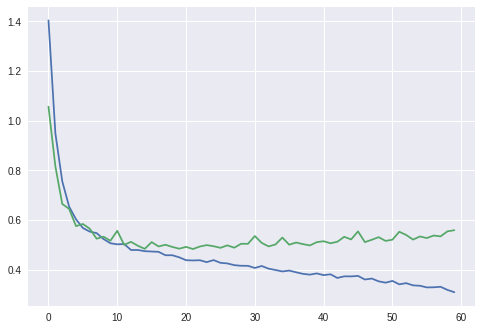

Best valid epoch: 22


In [34]:
from matplotlib import pyplot as plt
plt.plot(list(range(len(positives_asinh_spp_fit_history.history['loss']))),
         positives_asinh_spp_fit_history.history['loss'])
plt.plot(list(range(len(positives_asinh_spp_fit_history.history['val_loss']))),
         positives_asinh_spp_fit_history.history['val_loss'])
plt.show()
print("Best valid epoch:",np.argmin(positives_asinh_spp_fit_history.history['val_loss'])+1)

In [35]:
#Save the model
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/"My Drive"/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF/abhi_split_sets
positives_asinh_spp_model.save("abhitraintestsplits_positives_asinh_spp_model_2018Nov29_0415pm.h5")
%cd /content

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF
/content


In [39]:
from collections import OrderedDict
import numpy as np

def iterate_over_generator_in_batches(batch_size, generator):
  X_batch = []
  y_batch = []
  for (X_ex, y_ex, coor, fastastr) in generator:
    X_batch.append(X_ex)
    y_batch.append(y_ex)
    if (len(X_batch)==batch_size):
      yield np.array(X_batch), np.array(y_batch)
      X_batch = []
      y_batch = []
  if (len(X_batch) > 0):
    yield np.array(X_batch), np.array(y_batch)
    
def get_predictions_and_true_labels(bed_source, name_to_model): 
  generator = pyfasta_data_loader.SingleStreamSeqOnly(
     batch_size=None,
     bed_source=bed_source,
     fasta_data_source="hg38.genome.fa",
     rc_augment=True,
     num_to_load_for_eval=None, #not used
     labels_dtype="float",
     wrap_in_keys=["sequence", "output"],
     randomize_after_pass=False).get_generator(loop_infinitely=False)  
  name_to_predictions = OrderedDict()
  true_y = []
  for X_batch, y_batch in iterate_over_generator_in_batches(
                            batch_size=200, generator=generator):
    true_y.extend(y_batch)
    for name in name_to_model:
      if name not in name_to_predictions:
        name_to_predictions[name] = []
      name_to_predictions[name].extend(name_to_model[name].predict(
                                       {'sequence': X_batch}))
  for name in name_to_predictions:
    name_to_predictions[name] = np.array(name_to_predictions[name])
  return np.array(true_y), name_to_predictions
    
positives_asinh_spp_name_to_model = {'positives_asinh_spp_model': positives_asinh_spp_model}

test_positives_asinh_spp_y, test_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="test.tsv.gz",
    name_to_model=positives_asinh_spp_name_to_model)
train_positives_asinh_spp_y, train_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="train.tsv.gz",
    name_to_model=positives_asinh_spp_name_to_model)
valid_positives_asinh_spp_y, valid_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="val.tsv.gz",
    name_to_model=positives_asinh_spp_name_to_model)

Reading bed file test.tsv.gz into memory
Finished reading bed file into memory; got 7241rows


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: generator 'get_pyfasta_generator' raised StopIteration
  import sys


Reading bed file train.tsv.gz into memory
Finished reading bed file into memory; got 33794rows
Reading bed file val.tsv.gz into memory
Finished reading bed file into memory; got 7242rows


Split name test


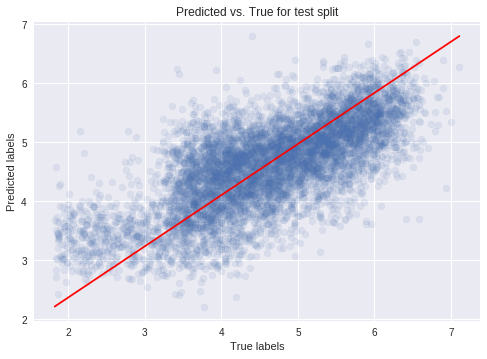

SpearmanrResult(correlation=0.6953824650662257, pvalue=0.0)
Split name valid


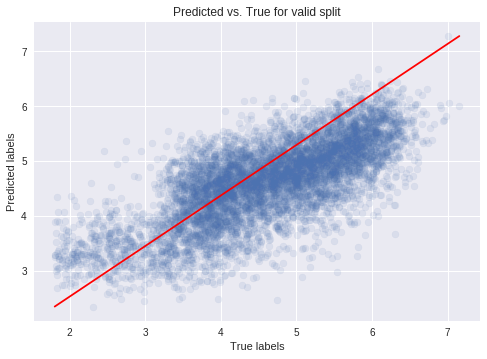

SpearmanrResult(correlation=0.7091340620619303, pvalue=0.0)
Split name train


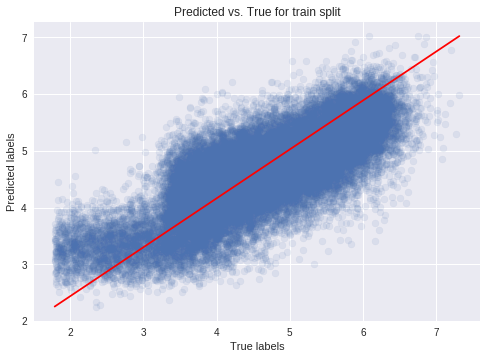

SpearmanrResult(correlation=0.7558715764482633, pvalue=0.0)


In [40]:
from scipy.stats import spearmanr
for split_name, split_labels, split_modelname_to_predictions in [
    ('test', test_positives_asinh_spp_y, test_positives_asinh_spp_name_to_predictions),
    ('valid', valid_positives_asinh_spp_y, valid_positives_asinh_spp_name_to_predictions),
    ('train', train_positives_asinh_spp_y, train_positives_asinh_spp_name_to_predictions)]:
  print("Split name",split_name)
  for modelname in split_modelname_to_predictions:
    plt.scatter(split_labels[:,0],
                split_modelname_to_predictions[modelname][:,0], alpha=0.1)
    plt.xlabel("True labels")
    plt.ylabel("Predicted labels")
    plt.title("Predicted vs. True for "+split_name+" split")
    plt.plot([np.min(split_labels), np.max(split_labels)],
             [np.min(split_modelname_to_predictions[modelname][:,0]),
              np.max(split_modelname_to_predictions[modelname][:,0])],
             color="red")
    plt.show()
    print(spearmanr(a=split_labels[:,0],
                    b=split_modelname_to_predictions[modelname][:,0]))